# Figure 7: radio afterglow

## Loading the BHNS population

In [17]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tabulate import tabulate
import h5py
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u
import scipy
from scipy import stats
from scipy.integrate import cumtrapz
from scipy.ndimage import gaussian_filter as gf
from matplotlib.lines import Line2D
import pandas
import corner
import sympy as sp
import os
from scipy.interpolate import RegularGridInterpolator
import matplotlib.gridspec as gridspec
from functions import * 
import sys
sys.path.insert(0, '../COMPAS')
from spin_class import * 

num = 1000000 #number of binaries
eos = "SFHo" #assumed EoS
table = h5py.File('./population_data/bhns_%i_%s_z10_mass_spin_thv_GWFAST.hdf5' %(num,eos),'r') #EM and GW population
mns_max = 2.058838 #NS maximum mass for the assumed SFHo EoS

DCOtype='BHNS'
poptype='A'
path = './population_data/COMPASCompactOutput_'+ DCOtype + '_' + poptype+'.h5' #from Broekgaarden+21 

distribution = 'NOT fixed' #or 'fixed' for the same mass distribution at each redshift (approximated redshift evolution)
spin_prescription = 'Zero' #/Qin21/Uniform/Bavera21

### --- Loading Population --- ###

print("Loading intrinsic population")
mbh = table['mbh'][()] #mass of the primary component
mns = table['mns'][()] #mass of the secondary component
lamb_ns = table['lamb_ns'][()] #NS deformability
spin_bh = table['spin_bh'][()] #BH spin
i_tilt = table['i_tilt'][()] #angle between spin and angular momentum 
z = table['z'][()] #redshift
dL = table['dL'][()] #luminosity distance
thv = table['thv'][()] #viewing angle
ra = table['ra'][()]
dec = table['dec'][()]
m_dyn = table['m_dyn'][()] #dynamical ejecta mass
v_dyn = table['v_dyn'][()] #dynamical ejecta velocity
m_disk = table['m_disk'][()] #disk mass
m_out = table['m_out'][()] #ejected mass
final_x = table['final_x'][()] #final spin
E_bkt = table['E_bkt'][()] #brekout energy
E_k_jet = table['E_k_jet'][()] #jet kinetic energy
Ec = table['Ec'][()] #jet core energy

print("Loading GW population")
snr_LVKO4 = table['snr_LVKO4'][()]
snr_LVKO4_duty = table['snr_LVKO4_duty'][()]
snr_LO4_duty = table['snr_LO4_duty'][()]
snr_LO4 = table['snr_LO4'][()]
snr_LVKIO5 = table['snr_LVKIO5'][()]
snr_LVKIO5_duty = table['snr_LVKIO5_duty'][()]
snr_LVKO5_duty = table['snr_LVKO5_duty'][()]

sky_loc_LVKO4 = table['sky_loc_LVKO4'][()]
sky_loc_LVKIO5 = table['sky_loc_LVKIO5'][()]
sky_loc_LO4 = table['sky_loc_LO4'][()]
sky_loc_LVKO4_duty = table['sky_loc_LVKO4_duty'][()]
sky_loc_LO4_duty = table['sky_loc_LO4_duty'][()]
sky_loc_LVKIO5_duty = table['sky_loc_LVKIO5_duty'][()]
sky_loc_LVKO5_duty = table['sky_loc_LVKO5_duty'][()]

print("Loading EM population (kilonova)")
kn_waves = table['kn_waves'][()] #KN bands = g, z, J
t_kn = table['t_kn'][()] #KN time
lc_kn = table['lc_kn'][()] #KN abs mag

print("Loading EM population (GRB afterglow)")
grb_nu = table['grb_nu'][()] #GRB afterglow bands
t_grb = table['t_grb'][()] #GRB afterglow time
lc_grb = table['lc_grb'][()] #GRB afterglow flux

print("Loading EM population (GRB prompt)")
prompt_band = table['prompt_band'][()] #GRB prompt bands
flux_prompt = table['flux_prompt'][()] #GRB prompt photon flux

table.close()

Loading intrinsic population
Loading GW population
Loading EM population (kilonova)
Loading EM population (GRB afterglow)
Loading EM population (GRB prompt)


## Weighing the BHNS population

In [18]:
### --- Weights --- ###

if poptype == 'A':
    w_type='w_000'
    r0 = 149 
    w_type_high = 'w_000'
    r0_high = 302
    w_type_low = 'w_000'
    r0_low = 62
    
if poptype == 'B':
    w_type='w_000'
    r0 = 20
    w_type_high = 'w_000'
    r0_high = 100
    w_type_low = 'w_000'
    r0_low = 10

spin = calculate_spin_olderCOMPASdata(data_path=path)
if spin_prescription == 'Bavera21':
    spinM1, spinM2  = spin.Bavera21()
if spin_prescription == 'Qin21':
    spinM1, spinM2  = spin.Qin21()
if spin_prescription == 'Uniform':
    spinM1, spinM2  = spin.Bavera21()
    spinM1 = np.random.uniform(0.,0.5,spinM1.shape)
    spinM2 = np.random.uniform(0.,0.5,spinM2.shape)
elif spin_prescription == 'Zero':
    spinM1, spinM2  = spin.Bavera21()
    spinM1 = np.random.uniform(0.,0.,spinM1.shape)
    spinM2 = np.random.uniform(0.,0.,spinM2.shape)

bhx=[2.5,27]
nsx=[1.1,3]
spinx=[0.,1.]
binsx=50
binsy=50
binsz=50

if distribution == 'fixed':
    C_mc, w = f_weights_fixed(mbh,mns,thv,spin_bh,z,r0,5.e-2,path,w_type,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
    C_mc_low, w_low = f_weights_fixed(mbh,mns,thv,spin_bh,z,r0_low,5.e-2,path,w_type_low,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
    C_mc_high, w_high = f_weights_fixed(mbh,mns,thv,spin_bh,z,r0_high,5.e-2,path,w_type_high,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
    
if distribution == 'NOT fixed':
    C_mc, w = f_weights(mbh,mns,thv,spin_bh,z,r0,path,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
    C_mc_low, w_low = f_weights(mbh,mns,thv,spin_bh,z,r0_low,path,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
    C_mc_high, w_high = f_weights(mbh,mns,thv,spin_bh,z,r0_high,path,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)

print("")
print("EoS:",eos)
print("Population model:",poptype)
print("The mass and spin distributions are", distribution)
if distribution == 'fixed':
    print("The fiducial SFRD is", w_type, "with r0 =", r0)
    print("The higher limit SFRD is", w_type_high, "with r0 =", r0_high)
    print("The lower limit SFRD is", w_type_low, "with r0 =", r0_low)
print("The spin prescription is:", spin_prescription)
print("")

Computing weights
Computing weights
Computing weights

EoS: SFHo
Population model: A
The mass and spin distributions are NOT fixed
The spin prescription is: Zero



In [19]:
### --- Limiting Thresholds --- ###
lim_snr =12.

lim_kn = np.linspace(20.,28.,10)
det_kn_g = np.zeros(len(lim_kn))
det_kn_g_100 = np.zeros(len(lim_kn))
det_kn_g_10 = np.zeros(len(lim_kn))
det_kn_z = np.zeros(len(lim_kn))
det_kn_J = np.zeros(len(lim_kn))
det_kn_g_lim = np.zeros(len(lim_kn))
det_kn_g_100_lim = np.zeros(len(lim_kn))
det_kn_g_10_lim = np.zeros(len(lim_kn))
det_kn_z_lim = np.zeros(len(lim_kn))
det_kn_J_lim = np.zeros(len(lim_kn))

lim_grb_radio = np.logspace(-9,2,100)
lim_grb_optic = np.logspace(-9,2,100)
lim_grb_x = np.logspace(-9,2,100)
det_grb_radio = np.zeros(len(lim_grb_radio))
det_grb_radio_100 = np.zeros(len(lim_grb_radio))
det_grb_radio_10 = np.zeros(len(lim_grb_radio))
det_grb_optic = np.zeros(len(lim_grb_optic))
det_grb_x = np.zeros(len(lim_grb_x))
det_radio = np.zeros(len(lim_grb_radio))
det_optic = np.zeros(len(lim_grb_optic))
det_x = np.zeros(len(lim_grb_x))
det_grb_radio_15 = np.zeros(len(lim_grb_radio))
det_grb_optic_15 = np.zeros(len(lim_grb_optic))
det_grb_x_15 = np.zeros(len(lim_grb_x))
det_radio_15 = np.zeros(len(lim_grb_radio))
det_optic_15 = np.zeros(len(lim_grb_optic))
det_x_15 = np.zeros(len(lim_grb_x))

det_grb_radio_lim = np.zeros(len(lim_grb_radio))
det_grb_radio_100_lim = np.zeros(len(lim_grb_radio))
det_grb_radio_10_lim = np.zeros(len(lim_grb_radio))
det_radio_lim = np.zeros(len(lim_grb_radio))

lim_prompt = np.logspace(-2,3,100)
det_fermi = np.zeros(len(lim_prompt))
det_swift = np.zeros(len(lim_prompt))
detfermi = np.zeros(len(lim_prompt))
detswift = np.zeros(len(lim_prompt))
det_fermi_15 = np.zeros(len(lim_prompt))
det_swift_15 = np.zeros(len(lim_prompt))
detfermi_15 = np.zeros(len(lim_prompt))
detswift_15 = np.zeros(len(lim_prompt))

x = np.sort(z)
s = np.argsort(z)

snr = [snr_LVKO4_duty, snr_LVKIO5_duty]
sky = [sky_loc_LVKO4_duty, sky_loc_LVKIO5_duty]

snr_lim = [snr_LO4_duty, snr_LVKO5_duty]
sky_lim = [sky_loc_LO4_duty, sky_loc_LVKO5_duty]


Computing KN limiting thresholds
Computing GRB AFTERGLOW limiting thresholds
Saturation rates O4 GRB Afterglow: 0.33582035840635416
Saturation rates O4 KN: 0.33582035840635416
Computing KN limiting thresholds
Computing GRB AFTERGLOW limiting thresholds
Saturation rates O5 GRB Afterglow: 2.1316782111136847
Saturation rates O5 KN: 2.1316782111136847


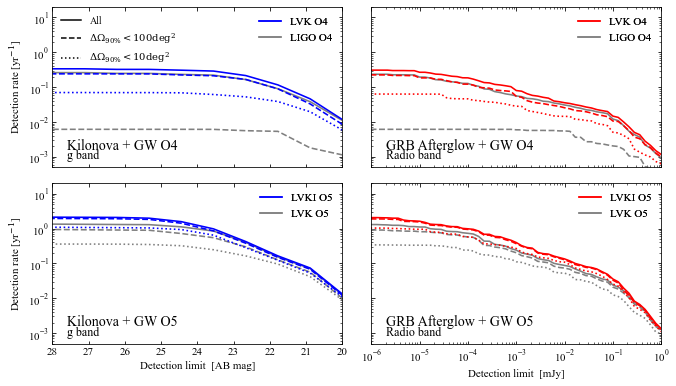

In [20]:
plt.rcParams['font.family']="Times New Roman"
plt.rcParams['figure.figsize']=9.5, 5.5
plt.rcParams['mathtext.fontset']='dejavuserif'

gs = gridspec.GridSpec(2,2,top=0.95,right=0.97,left=0.08,wspace=0.1,hspace=0.1,bottom=0.1) 

for k in range(0,len(snr)):
    gw_snr = snr[k]
    sky_loc = sky[k]
    gw_det = gw_snr >= lim_snr
    
    gw_snr_lim = snr_lim[k]
    sky_loc_lim = sky_lim[k]
    gw_det_lim = gw_snr_lim >= lim_snr
     
    #KILONOVA
    print("Computing KN limiting thresholds")
    kn_peak = np.min(lc_kn, axis=2)
    kn_det = np.zeros([num,len(kn_waves)],dtype=bool)
    for i in range(len(lim_kn)):
        for j in range(len(kn_waves)):
            kn_peak_APP = abs_to_app(kn_peak[:,j],dL[:]*1.e6)
            kn_det[:,j] = kn_peak_APP <= lim_kn[i]
        kn_det_g = kn_det[:,0]
        kn_det_z = kn_det[:,1]
        kn_det_J = kn_det[:,2]
        cum_gw_kn_g = C_mc*np.cumsum(w[s]*kn_det_g[s]*gw_det[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
        cum_gw_kn_g_100 = C_mc*np.cumsum(w[s]*kn_det_g[s]*gw_det[s]*(sky_loc[s]<100.)*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
        cum_gw_kn_g_10 = C_mc*np.cumsum(w[s]*kn_det_g[s]*gw_det[s]*(sky_loc[s]<10.)*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
        cum_gw_kn_z = C_mc*np.cumsum(w[s]*kn_det_z[s]*gw_det[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
        cum_gw_kn_J = C_mc*np.cumsum(w[s]*kn_det_J[s]*gw_det[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6)))
        det_kn_g[i] = cum_gw_kn_g[-1]
        det_kn_g_100[i] = cum_gw_kn_g_100[-1]
        det_kn_g_10[i] = cum_gw_kn_g_10[-1]
        det_kn_z[i] = cum_gw_kn_z[-1]
        det_kn_J[i] = cum_gw_kn_J[-1]
        
        cum_gw_kn_g_lim = C_mc*np.cumsum(w[s]*kn_det_g[s]*gw_det_lim[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
        cum_gw_kn_g_100_lim  = C_mc*np.cumsum(w[s]*kn_det_g[s]*gw_det_lim[s]*(sky_loc_lim[s]<100.)*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
        cum_gw_kn_g_10_lim  = C_mc*np.cumsum(w[s]*kn_det_g[s]*gw_det_lim[s]*(sky_loc_lim[s]<10.)*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
        cum_gw_kn_z_lim  = C_mc*np.cumsum(w[s]*kn_det_z[s]*gw_det_lim[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
        cum_gw_kn_J_lim  = C_mc*np.cumsum(w[s]*kn_det_J[s]*gw_det_lim[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6)))
        det_kn_g_lim[i] = cum_gw_kn_g_lim[-1]
        det_kn_g_100_lim[i] = cum_gw_kn_g_100_lim[-1]
        det_kn_g_10_lim[i] = cum_gw_kn_g_10_lim[-1]
        det_kn_z_lim[i] = cum_gw_kn_z_lim[-1]
        det_kn_J_lim[i] = cum_gw_kn_J_lim[-1]
         
    #GRB AFTERGLOW
    print("Computing GRB AFTERGLOW limiting thresholds")
    grb_peak = np.max(lc_grb, axis=2)
    grb_det = np.zeros([num,len(grb_nu)],dtype=bool)
    grb_det_15 = np.zeros([num,len(grb_nu)],dtype=bool)
    for i in range(len(lim_grb_x)):
        grb_det[:,0] = grb_peak[:,0,0] >= lim_grb_radio[i]
        grb_det[:,1] = grb_peak[:,1,0] >= lim_grb_optic[i]
        grb_det[:,2] = grb_peak[:,2,0] >= lim_grb_x[i]
        grb_det_15[:,0] = grb_peak[:,0,1] >= lim_grb_radio[i]
        grb_det_15[:,1] = grb_peak[:,1,1] >= lim_grb_optic[i]
        grb_det_15[:,2] = grb_peak[:,2,1] >= lim_grb_x[i]
        grb_det_radio = grb_det[:,0]
        grb_det_optic = grb_det[:,1]
        grb_det_x = grb_det[:,2]
        cum_gw_grb_radio =  C_mc*np.cumsum(w[s]*grb_det_radio[s]*gw_det[s]*(m_disk[s]>1.e-5))    
        cum_gw_grb_radio_100 =  C_mc*np.cumsum(w[s]*grb_det_radio[s]*gw_det[s]*(sky_loc[s]<100.)*(m_disk[s]>1.e-5)) 
        cum_gw_grb_radio_10 =  C_mc*np.cumsum(w[s]*grb_det_radio[s]*gw_det[s]*(sky_loc[s]<10.)*(m_disk[s]>1.e-5)) 
        cum_gw_grb_radio_lim =  C_mc*np.cumsum(w[s]*grb_det_radio[s]*gw_det_lim[s]*(m_disk[s]>1.e-5))    
        cum_gw_grb_radio_100_lim =  C_mc*np.cumsum(w[s]*grb_det_radio[s]*gw_det_lim[s]*(sky_loc_lim[s]<100.)*(m_disk[s]>1.e-5)) 
        cum_gw_grb_radio_10_lim =  C_mc*np.cumsum(w[s]*grb_det_radio[s]*gw_det_lim[s]*(sky_loc_lim[s]<10.)*(m_disk[s]>1.e-5))      
        cum_gw_grb_optic =  C_mc*np.cumsum(w[s]*grb_det_optic[s]*gw_det[s])    
        cum_gw_grb_x =  C_mc*np.cumsum(w[s]*grb_det_x[s]*gw_det[s])
        det_grb_radio[i] = cum_gw_grb_radio[-1]
        det_grb_radio_100[i] = cum_gw_grb_radio_100[-1]
        det_grb_radio_10[i] = cum_gw_grb_radio_10[-1]
        det_grb_radio_lim[i] = cum_gw_grb_radio_lim[-1]
        det_grb_radio_100_lim[i] = cum_gw_grb_radio_100_lim[-1]
        det_grb_radio_10_lim[i] = cum_gw_grb_radio_10_lim[-1]
        det_grb_optic[i] = cum_gw_grb_optic[-1]
        det_grb_x[i] = cum_gw_grb_x[-1] 
    
    plt.subplot(gs[2*k+1])
    plt.plot(lim_grb_radio,det_grb_radio_lim,color="grey",ls="-",linewidth=1.6,label="All")
    plt.plot(lim_grb_radio,det_grb_radio_100_lim,color="grey",ls="--",linewidth=1.6,label=r"$\Delta\Omega_{{\rm 90}\%}<100\mathrm{deg}^2$")
    plt.plot(lim_grb_radio,det_grb_radio_10_lim,color="grey",ls=":",linewidth=1.6,label=r"$\Delta\Omega_{{\rm 90}\%}<10\mathrm{deg}^2$")
    plt.plot(lim_grb_radio,det_grb_radio,color="r",ls="-",linewidth=1.6)
    plt.plot(lim_grb_radio,det_grb_radio_100,color="r",ls="--",linewidth=1.6)
    plt.plot(lim_grb_radio,det_grb_radio_10,color="r",ls=":",linewidth=1.6)
    
    plt.tick_params(which='both',direction='in',left=True,bottom=True,top=True,right=True,labelsize=11)
    plt.yticks(color='w')
    plt.xscale("log")
    plt.yscale("log")
    #plt.ylabel(r'Detection rate [yr$^{-1}$]',size=11)
    plt.xlim((1.e-6,1.))
    plt.ylim((5.e-4,2.e1))
    plt.annotate('Radio band', xy=(0.05, 0.05), xycoords='axes fraction',size=12)
    if k == 0:
        plt.annotate('GRB Afterglow + GW O4', xy=(0.05, 0.11), xycoords='axes fraction',size=14)
        leg3=plt.legend([Line2D([0],[0],color='r'),Line2D([0],[0],color='grey',ls="-")],["LVK O4","LIGO O4"],loc=1,prop={'size': 11},frameon=False)
        plt.gca().add_artist(leg3)
        plt.xticks(color='w')
        print ("Saturation rates O4 GRB Afterglow:", det_grb_radio[0])
        
    if k == 1:
        plt.annotate('GRB Afterglow + GW O5', xy=(0.05, 0.11), xycoords='axes fraction',size=14)
        leg3=plt.legend([Line2D([0],[0],color='r'),Line2D([0],[0],color='grey',ls="-")],["LVKI O5","LVK O5"],loc=1,prop={'size': 11},frameon=False)
        plt.gca().add_artist(leg3)
        plt.xlabel(r'Detection limit  [mJy]',size=11)
        print ("Saturation rates O5 GRB Afterglow:", det_grb_radio[0])
    
    plt.subplot(gs[2*k])
    plt.plot(lim_kn,det_kn_g_lim,color="grey",ls="-",linewidth=1.6,label="All")
    plt.plot(lim_kn,det_kn_g_100_lim,color="grey",ls="--",linewidth=1.6,label=r"$\Delta\Omega_{{\rm 90}\%}<100\mathrm{deg}^2$")
    plt.plot(lim_kn,det_kn_g_10_lim,color="grey",ls=":",linewidth=1.6,label=r"$\Delta\Omega_{{\rm 90}\%}<10\mathrm{deg}^2$")
    plt.plot(lim_kn,det_kn_g,color="b",ls="-",linewidth=1.6)
    plt.plot(lim_kn,det_kn_g_100,color="b",ls="--",linewidth=1.6)
    plt.plot(lim_kn,det_kn_g_10,color="b",ls=":",linewidth=1.6)

    plt.tick_params(which='both',direction='in',left=True,bottom=True,top=True,right=True,labelsize=11)
    #plt.xscale("log")
    plt.yscale("log")
    plt.ylabel(r'Detection rate [yr$^{-1}$]',size=11)
    plt.xlim((20,28))
    plt.ylim((5.e-4,2.e1))
    plt.annotate('g band', xy=(0.05, 0.05), xycoords='axes fraction',size=12)
    plt.gca().invert_xaxis()
    if k == 0:
        plt.annotate('Kilonova + GW O4', xy=(0.05, 0.11), xycoords='axes fraction',size=14)
        leg1=plt.legend([Line2D([0],[0],color='black'),Line2D([0],[0],color='black',ls="--"),Line2D([0],[0],color='black',ls=":")],["All",r"$\Delta\Omega_{{\rm 90}\%}<100\mathrm{deg}^2$",r"$\Delta\Omega_{{\rm 90}\%}<10\mathrm{deg}^2$"],loc=2,prop={'size': 10},frameon=False)
        plt.gca().add_artist(leg1)
        leg2=plt.legend([Line2D([0],[0],color='b'),Line2D([0],[0],color='grey',ls="-")],["LVK O4","LIGO O4"],loc=1,prop={'size': 11},frameon=False)
        plt.gca().add_artist(leg2)
        plt.xticks(color='w')
        print ("Saturation rates O4 KN:", det_kn_g[-1])
    if k == 1:
        plt.annotate('Kilonova + GW O5', xy=(0.05, 0.11), xycoords='axes fraction',size=14)
        leg2=plt.legend([Line2D([0],[0],color='b'),Line2D([0],[0],color='grey',ls="-")],["LVKI O5","LVK O5"],loc=1,prop={'size': 11},frameon=False)
        plt.gca().add_artist(leg2)
        plt.xlabel(r'Detection limit  [AB mag]',size=11)
        print ("Saturation rates O5 KN:", det_kn_g[-1])

plt.show()

Computing KN limiting thresholds
Computing GRB AFTERGLOW limiting thresholds
Computing GRB PROMPT limiting thresholds
Saturation rates O4 GRB Afterglow: 0.33582035840635416
Saturation rates O4 GRB prompt: 0.00047972056477071977
Computing KN limiting thresholds
Computing GRB AFTERGLOW limiting thresholds
Computing GRB PROMPT limiting thresholds
Saturation rates O5 GRB Afterglow: 2.1316782111136847
Saturation rates O5 GRB prompt: 0.0005779335501620166


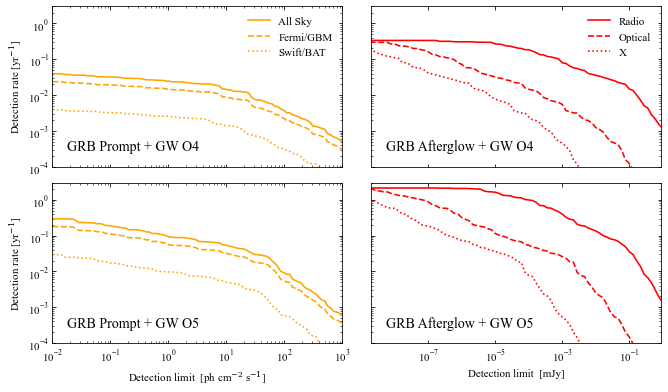

In [21]:
plt.rcParams['font.family']="Times New Roman"
plt.rcParams['figure.figsize']=9.5, 5.5
plt.rcParams['mathtext.fontset']='dejavuserif'

gs = gridspec.GridSpec(2,2,top=0.95,right=0.97,left=0.08,wspace=0.1,hspace=0.1,bottom=0.1) 

snr = [snr_LVKO4_duty, snr_LVKIO5_duty]
sky = [sky_loc_LVKO4_duty, sky_loc_LVKIO5_duty]

for k in range(0,len(snr)):
    gw_snr = snr[k]
    sky_loc = sky[k]
    
    gw_det = gw_snr >= lim_snr
    
    #KILONOVA
    print("Computing KN limiting thresholds")
    kn_peak = np.min(lc_kn, axis=2)
    kn_det = np.zeros([num,len(kn_waves)],dtype=bool)
    for i in range(len(lim_kn)):
        for j in range(len(kn_waves)):
            kn_peak_APP = abs_to_app(kn_peak[:,j],dL[:]*1.e6)
            kn_det[:,j] = kn_peak_APP <= lim_kn[i]
        kn_det_g = kn_det[:,0]
        kn_det_z = kn_det[:,1]
        kn_det_J = kn_det[:,2]
        cum_gw_kn_g = C_mc*np.cumsum(w[s]*kn_det_g[s]*gw_det[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
        cum_gw_kn_g_100 = C_mc*np.cumsum(w[s]*kn_det_g[s]*gw_det[s]*(sky_loc[s]<100.)*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
        cum_gw_kn_g_10 = C_mc*np.cumsum(w[s]*kn_det_g[s]*gw_det[s]*(sky_loc[s]<10.)*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
        cum_gw_kn_z = C_mc*np.cumsum(w[s]*kn_det_z[s]*gw_det[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
        cum_gw_kn_J = C_mc*np.cumsum(w[s]*kn_det_J[s]*gw_det[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6)))
        det_kn_g[i] = cum_gw_kn_g[-1]
        det_kn_g_100[i] = cum_gw_kn_g_100[-1]
        det_kn_g_10[i] = cum_gw_kn_g_10[-1]
        det_kn_z[i] = cum_gw_kn_z[-1]
        det_kn_J[i] = cum_gw_kn_J[-1]
        
        cum_gw_kn_g_lim = C_mc*np.cumsum(w[s]*kn_det_g[s]*gw_det_lim[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
        cum_gw_kn_g_100_lim  = C_mc*np.cumsum(w[s]*kn_det_g[s]*gw_det_lim[s]*(sky_loc_lim[s]<100.)*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
        cum_gw_kn_g_10_lim  = C_mc*np.cumsum(w[s]*kn_det_g[s]*gw_det_lim[s]*(sky_loc_lim[s]<10.)*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
        cum_gw_kn_z_lim  = C_mc*np.cumsum(w[s]*kn_det_z[s]*gw_det_lim[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
        cum_gw_kn_J_lim  = C_mc*np.cumsum(w[s]*kn_det_J[s]*gw_det_lim[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6)))
        det_kn_g_lim[i] = cum_gw_kn_g_lim[-1]
        det_kn_g_100_lim[i] = cum_gw_kn_g_100_lim[-1]
        det_kn_g_10_lim[i] = cum_gw_kn_g_10_lim[-1]
        det_kn_z_lim[i] = cum_gw_kn_z_lim[-1]
        det_kn_J_lim[i] = cum_gw_kn_J_lim[-1]
         
    #GRB AFTERGLOW
    print("Computing GRB AFTERGLOW limiting thresholds")
    grb_peak = np.max(lc_grb, axis=2)
    grb_det = np.zeros([num,len(grb_nu)],dtype=bool)
    grb_det_15 = np.zeros([num,len(grb_nu)],dtype=bool)
    for i in range(len(lim_grb_x)):
        grb_det[:,0] = grb_peak[:,0,0] >= lim_grb_radio[i]
        grb_det[:,1] = grb_peak[:,1,0] >= lim_grb_optic[i]
        grb_det[:,2] = grb_peak[:,2,0] >= lim_grb_x[i]
        grb_det_15[:,0] = grb_peak[:,0,1] >= lim_grb_radio[i]
        grb_det_15[:,1] = grb_peak[:,1,1] >= lim_grb_optic[i]
        grb_det_15[:,2] = grb_peak[:,2,1] >= lim_grb_x[i]
        grb_det_radio = grb_det[:,0]
        grb_det_optic = grb_det[:,1]
        grb_det_x = grb_det[:,2]
        cum_gw_grb_radio =  C_mc*np.cumsum(w[s]*grb_det_radio[s]*gw_det[s]*(m_disk[s]>1.e-5))     
        cum_gw_grb_optic =  C_mc*np.cumsum(w[s]*grb_det_optic[s]*gw_det[s])    
        cum_gw_grb_x =  C_mc*np.cumsum(w[s]*grb_det_x[s]*gw_det[s])
        det_grb_radio[i] = cum_gw_grb_radio[-1]
        det_grb_optic[i] = cum_gw_grb_optic[-1]
        det_grb_x[i] = cum_gw_grb_x[-1]
    
    #GRB PROMPT
    print("Computing GRB PROMPT limiting thresholds")
    for i in range(len(lim_prompt)):
        prompt_det_fermi = flux_prompt[:,0,0] >= lim_prompt[i]
        prompt_det_swift = flux_prompt[:,1,0] >= lim_prompt[i] 
        prompt_det_fermi_15 = flux_prompt[:,0,1] >= lim_prompt[i]
        prompt_det_swift_15 = flux_prompt[:,1,1] >= lim_prompt[i]
        cum_gw_fermi = C_mc*np.cumsum(w[s]*prompt_det_fermi[s]*gw_det[s]*(m_disk[s]>1.e-5))
        cum_gw_swift = C_mc*np.cumsum(w[s]*prompt_det_swift[s]*gw_det[s]*(m_disk[s]>1.e-5))
        det_fermi[i] = cum_gw_fermi[-1]
        det_swift[i] = cum_gw_swift[-1] 
        cum_gw_fermi = C_mc*np.cumsum(w[s]*prompt_det_fermi[s])
        cum_gw_swift = C_mc*np.cumsum(w[s]*prompt_det_swift[s])
        detfermi[i] = cum_gw_fermi[-1]
        detswift[i] = cum_gw_swift[-1]
    
    plt.subplot(gs[2*k+1])
    plt.plot(lim_grb_radio,det_grb_radio,color="r",ls="-",linewidth=1.6,label="Radio")
    plt.plot(lim_grb_optic,det_grb_optic,color="r",ls="--",linewidth=1.6,label="Optical")
    plt.plot(lim_grb_x,det_grb_x,color="r",ls=":",linewidth=1.6,label="X")
    
    plt.tick_params(which='both',direction='in',left=True,bottom=True,top=True,right=True,labelsize=11)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim((2.e-9,0.9))
    plt.ylim((1.e-4,3.))
    plt.yticks(color='w')
    
    if k == 0:
        plt.annotate('GRB Afterglow + GW O4', xy=(0.05, 0.1), xycoords='axes fraction',size=14)
        plt.legend(loc=1,frameon=False,prop={'size': 11})
        plt.xticks(color='w')
        print ("Saturation rates O4 GRB Afterglow:", det_grb_radio[0])
        
    if k == 1:
        plt.annotate('GRB Afterglow + GW O5', xy=(0.05, 0.1), xycoords='axes fraction',size=14)
        #plt.legend(loc=1,frameon=False,prop={'size': 11})
        plt.xlabel(r'Detection limit  [mJy]',size=11)
        print ("Saturation rates O5 GRB Afterglow:", det_grb_radio[0])
        
    plt.subplot(gs[2*k])
    plt.plot(lim_prompt,det_fermi,ls='-',c='orange',linewidth=1.6,label="All Sky")
    plt.plot(lim_prompt,det_fermi*0.6,ls='--',c='orange',linewidth=1.6,label="Fermi/GBM")
    plt.plot(lim_prompt,det_swift*0.11,ls=':',c='orange',linewidth=1.6,label="Swift/BAT")
    
    plt.tick_params(which='both',direction='in',left=True,bottom=True,top=True,right=True,labelsize=11)
    plt.ylabel(r'Detection rate [yr$^{-1}$]',size=11)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim((1.e-2,1.e3))
    plt.ylim((1.e-4,3.))
    
    if k == 0:
        plt.annotate('GRB Prompt + GW O4', xy=(0.05, 0.1), xycoords='axes fraction',size=14)
        plt.legend(loc=1,frameon=False,prop={'size': 11})
        plt.xticks(color='w')
        print ("Saturation rates O4 GRB prompt:", det_fermi[-1])
    if k == 1:
        plt.annotate('GRB Prompt + GW O5', xy=(0.05, 0.1), xycoords='axes fraction',size=14)
        plt.xlabel(r'Detection limit  [ph cm$^{-2}$ s$^{-1}$]',size=11)
        print ("Saturation rates O5 GRB prompt:", det_fermi[-1])

plt.show()